In [1]:
REPO_ROOT = '../repos/xView2_first_place/'

In [2]:
import os
import cv2
import numpy as np
import tiffile

In [5]:
test_path = '../datasets/geotiffs/test/'

In [14]:
imgs_to_test = []
d = []
num = 10
count = 0
for img_name in os.listdir(test_path+'images'):
    disaster, img_num, post_pre, _ = img_name.split('_')
    if disaster not in d and post_pre == 'pre':
        imgs_to_test.append(os.path.join(test_path+'images', img_name))
        imgs_to_test.append(os.path.join(test_path+'images', '%s_%s_post_disaster.tif' % (disaster, img_num )))
        count+=1
    if count > num:
        break

In [15]:
for img_path in imgs_to_test:
    tif = tiffile.imread(img_path)
    img = cv2.cvtColor(np.uint8(tif), cv2.COLOR_RGB2BGR)
    b = os.path.basename(img_path).split('.')[0]+'.png'
    cv2.imwrite(os.path.join("../repos/xView2_first_place/test/images", b), img)

Calculating metrics using 16 cpus...
Wrote metrics to score.txt


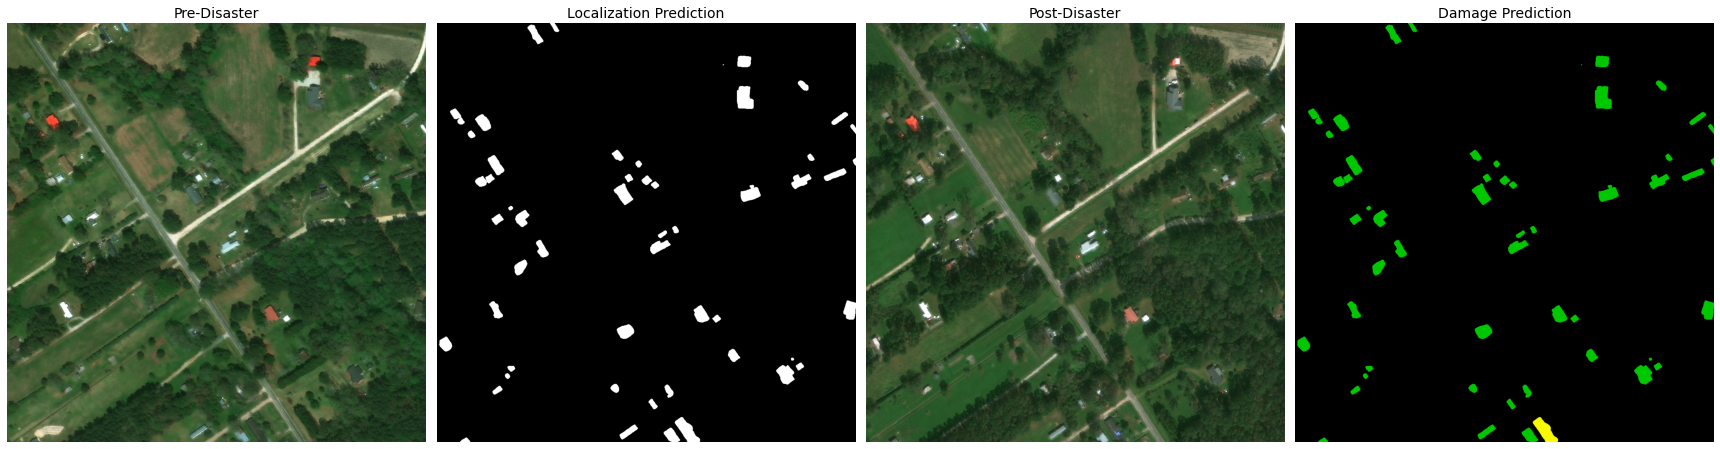

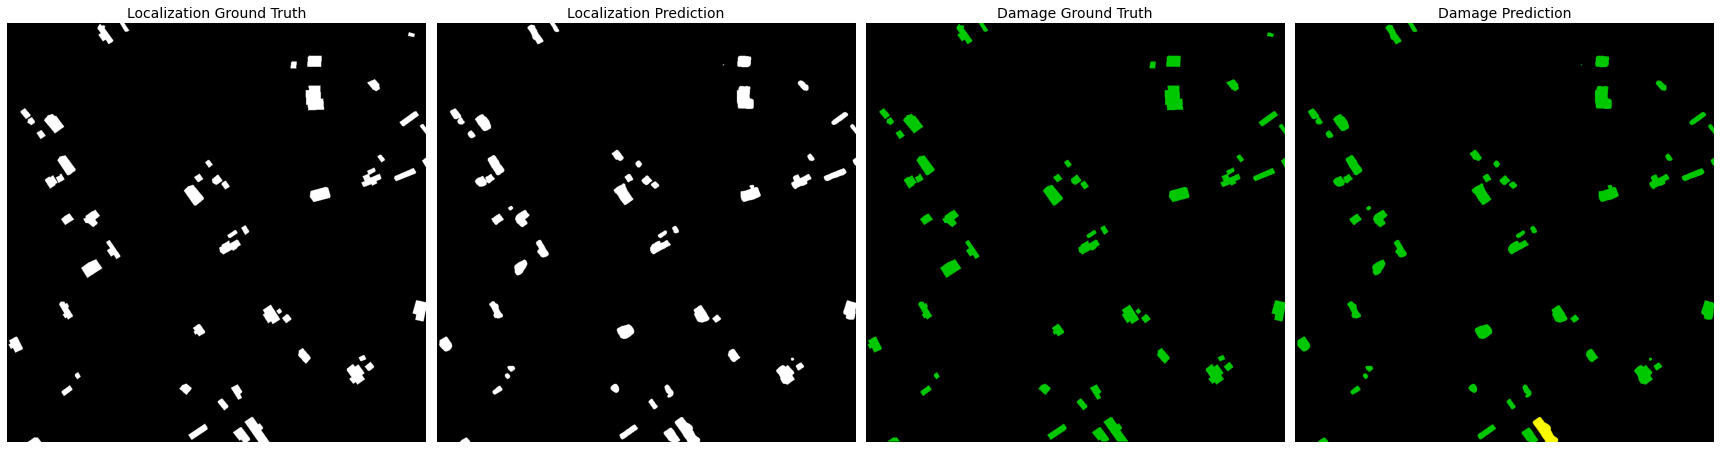

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import tiffile
import json
import shapely.wkt
from PIL import Image, ImageDraw

pre_path = "../datasets/geotiffs/test/images/hurricane-florence_00000294_pre_disaster.tif"
post_path = "../datasets/geotiffs/test/images/hurricane-florence_00000294_post_disaster.tif"

post_lbl_path = '../datasets/geotiffs/test/labels/hurricane-florence_00000294_post_disaster.json'
pre_lbl_path = '../datasets/geotiffs/test/labels/hurricane-florence_00000294_pre_disaster.json'

validation_root = '../validation/'

with open(post_lbl_path, 'r') as infile:
    post_lbl = json.load(infile)
with open(pre_lbl_path, 'r') as infile:
    pre_lbl = json.load(infile)

damage_polys = {}
polys = []
for feat in pre_lbl['features']['xy']:
    #Check if feature is a building
    if feat['properties']['feature_type'] == 'building':
        poly_pre = shapely.wkt.loads(feat['wkt'])
        polys.append(poly_pre)
        
for feat in post_lbl['features']['xy']:
    #Check if feature is a building
    if feat['properties']['feature_type'] == 'building':
        uid = feat["properties"]["uid"]
        damage = feat["properties"]["subtype"]
        poly_post = shapely.wkt.loads(feat['wkt'])
        damage_polys[uid] = []
        damage_polys[uid].append(poly_post)
        damage_polys[uid].append(damage)
        
pre_tif = tiffile.imread(pre_path).copy()
post_tif = tiffile.imread(post_path).copy()

loc_mask = create_loc_mask(pre_tif, polys, evaluate=True)
cls_mask = create_cls_mask(post_tif, damage_polys, evaluate=True)

#Write these to validation folder
d, num = os.path.basename(pre_lbl_path).split('_')[:2]
target_path = os.path.join(validation_root,'targets')
cv2.imwrite(os.path.join(target_path, 'test_localization_%s_target.png'%(num)), loc_mask)
cv2.imwrite(os.path.join(target_path, 'test_damage_%s_target.png'%(num)), cls_mask)


loc_path = "../repos/xView2_first_place/submission/hurricane-florence_00000294_localization_disaster_prediction.png"
damage_path = "../repos/xView2_first_place/submission/hurricane-florence_00000294_damage_disaster_prediction.png"

#Copy to validation
pred_path = os.path.join(validation_root+'predictions')
os.system("cp %s %s" % (loc_path, os.path.join(pred_path, 'test_localization_%s_prediction.png'%(num))))
os.system("cp %s %s" % (damage_path, os.path.join(pred_path, 'test_damage_%s_prediction.png'%(num))))

#Evaluate
evaluator = xview2_metrics.XviewMetrics(pred_path, target_path)
evaluator.compute_score(pred_path, target_path, 'score.txt')

#Redo masks for display 
loc_mask = create_loc_mask(pre_tif, polys, evaluate=False)
cls_mask = create_cls_mask(post_tif, damage_polys, evaluate=False)

colors_dict = { 1:[0, 200, 0], 
                2:[250,250,0],
                3:[250,100,20], 
                4:[250,20,20]
                }

loc_sub = cv2.imread(loc_path)
damage_sub = cv2.imread(damage_path)

for key in colors_dict.keys():
    damage_sub[np.where(damage_sub == key)[0],np.where(damage_sub == key)[1],:] =  colors_dict[key]
loc_sub[np.where(loc_sub == 1)[0],np.where(loc_sub == 1)[1],:] = [255,255,255]


fig,ax = plt.subplots(1,4)
fig.set_size_inches(24,9)
fig.set_facecolor('w')

ax[0].imshow(pre_tif)
ax[0].set_title('Pre-Disaster', fontsize=14)

ax[1].imshow(loc_sub)
ax[1].set_title('Localization Prediction', fontsize=14)

ax[2].imshow(post_tif)
ax[2].set_title('Post-Disaster', fontsize=14)

ax[3].imshow(damage_sub)
ax[3].set_title('Damage Prediction', fontsize=14)

#Turn off the axis
for a in ax:
    a.axis('off')

plt.tight_layout()
plt.savefig('./figures/xview2_1st_place_sub_test_hurricane_florence.png')
plt.show()

fig,ax = plt.subplots(1,4)
fig.set_size_inches(24,9)
fig.set_facecolor('w')

ax[0].imshow(loc_mask)
ax[0].set_title('Localization Ground Truth', fontsize=14)

ax[1].imshow(loc_sub)
ax[1].set_title('Localization Prediction', fontsize=14)

ax[2].imshow(cls_mask)
ax[2].set_title('Damage Ground Truth', fontsize=14)

ax[3].imshow(damage_sub)
ax[3].set_title('Damage Prediction', fontsize=14)

#Turn off the axis
for a in ax:
    a.axis('off')

plt.tight_layout()
plt.savefig('./figures/xview2_1st_place_sub_test_hurricane_florence_gt_comp.png')
plt.show()



In [138]:
os.chdir('/home/francisco/Work/xplorespace/repos/xView2_scoring/')
import xview2_metrics
os.chdir('/home/francisco/Work/xplorespace/notebooks/')

In [149]:
tiffile.imread('../datasets/geotiffs/test/images/hurricane-michael_00000091_pre_disaster.tif')

TiffFileError: not a TIFF file

In [144]:
!ls


buildings_similarity.txt  figures  Untitled.ipynb  xBD_Dataset.ipynb


In [58]:
colors_dict = { 1:[0, 200, 0], 
                2:[250,250,0],
                3:[250,100,20], 
                4:[250,20,20]
                }

In [72]:
for key in colors_dict.keys():
    damage_sub[np.where(damage_sub == key)[0],np.where(damage_sub == key)[1],:] =  colors_dict[key]
loc_sub[np.where(loc_sub == 1)[0],np.where(loc_sub == 1)[1],:] = [255,255,255]

In [46]:
damage_sub[np.argwhere(damage_sub == [0,0,0])] = [1,1,1]

In [47]:
damage_sub

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [157]:
def create_loc_mask(tif, polys, evaluate=False):
    #Convert tif to PIL Image
    img = Image.fromarray(np.uint8(tif))
    if not evaluate:
        mask = Image.new("RGB", img.size, (0,0,0)) #concept-mode L is 8bit pixels, black and white
        draw = ImageDraw.Draw(mask)
        for poly in polys:
            x,y = poly.exterior.xy
            draw.polygon(list(zip(x,y)), fill=(255,255,255), outline=None)
    else:
        mask = Image.new("L", img.size, 0) #concept-mode L is 8bit pixels, black and white
        draw = ImageDraw.Draw(mask)
        for poly in polys:
            x,y = poly.exterior.xy
            draw.polygon(list(zip(x,y)), fill=1, outline=None)
    return np.asarray(mask)

def create_cls_mask(tif, poly_dict, evaluate=False):
    damage_level_dict = {'pre-disaster':(180,180,180),
                     'no-damage':(0, 200, 0,), 
                     'minor-damage':(250,250,0),
                     'major-damage':(250,100,20), 
                     'destroyed':(250,20,20),
                     'un-classified':(180,180,180)}
    #Convert tif to PIL Image
    img = Image.fromarray(np.uint8(tif))
    if not evaluate:
        mask = Image.new("RGB", img.size, (0,0,0)) #concept-mode L is 8bit pixels, black and white
        draw = ImageDraw.Draw(mask)
        for uid in poly_dict.keys():
            poly_post, damage = poly_dict[uid]
            x,y = poly_post.exterior.xy
            color = damage_level_dict[damage]
            draw.polygon(list(zip(x,y)), fill=color, outline=None)
    else:
        c_dict = {'no-damage':1, 
                     'minor-damage':2,
                     'major-damage':3, 
                     'destroyed':4}
        mask = Image.new("L", img.size, 0) #concept-mode L is 8bit pixels, black and white
        draw = ImageDraw.Draw(mask)
        for uid in poly_dict.keys():
            poly_post, damage = poly_dict[uid]
            x,y = poly_post.exterior.xy
            color = c_dict[damage]
            draw.polygon(list(zip(x,y)), fill=color, outline=None)
    return np.asarray(mask)


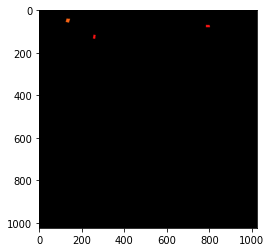

In [130]:
plt.imshow(cls_mask)

In [121]:
for key in damage_polys.keys():
    a,b = damage_polys[key]
    print(a)

POLYGON ((256.7154811406284 115.752896360013, 265.6138911301942 117.121882511485, 263.9026584398546 135.9454421062141, 253.2930157589502 133.207469802271, 256.0309880638931 117.8063755902183, 256.7154811406284 115.752896360013))
POLYGON ((145.3946807054521 41.5097029005446, 140.2609826351828 58.96427633980531, 136.1540241770192 58.96427634180351, 125.2021349604947 55.19956442525554, 130.6780795676329 39.11397713646772, 137.5230103274924 41.5097029005446, 140.945475708671 40.14071674907261, 145.3946807054521 41.5097029005446))
POLYGON ((801.7043582078003 71.70588019735861, 802.3227838402715 80.30880890480827, 784.2740155422661 80.55513109445351, 784.0058564230974 70.90140284534795, 786.1511293674547 69.82876637466825, 799.8272443821122 70.09692548934086, 801.7043582078003 71.70588019735861))


In [168]:
from tqdm import tqdm
test_folder = '../datasets/geotiffs/test/'
destination_folder = '../repos/xView2_first_place/test/'

images = [os.path.join(test_folder+'images', img_name) for img_name in os.listdir(test_folder+'images') if 'post' in img_name]

for i, post_img_path in tqdm(enumerate(images), desc="Processing Dataset"):
    basename = os.path.basename(post_img_path)
    disaster, img_num, _,_ = basename.split('_')
    
    pre_img_path = os.path.join(os.path.dirname(post_img_path), "%s_%s_pre_disaster.tif" % (disaster, img_num))
    
    pre_lbl_path = os.path.join(test_folder + 'labels', "%s_%s_pre_disaster.json" % (disaster, img_num))
    post_lbl_path = os.path.join(test_folder + 'labels', "%s_%s_post_disaster.json"% (disaster, img_num))
    
    with open(post_lbl_path, 'r') as infile:
        post_lbl = json.load(infile)
    with open(pre_lbl_path, 'r') as infile:
        pre_lbl = json.load(infile)

    damage_polys = {}
    polys = []
    for feat in pre_lbl['features']['xy']:
        #Check if feature is a building
        if feat['properties']['feature_type'] == 'building':
            poly_pre = shapely.wkt.loads(feat['wkt'])
            polys.append(poly_pre)

    for feat in post_lbl['features']['xy']:
        #Check if feature is a building
        if feat['properties']['feature_type'] == 'building':
            uid = feat["properties"]["uid"]
            damage = feat["properties"]["subtype"]
            if damage != 'un-classified':
                poly_post = shapely.wkt.loads(feat['wkt'])
                damage_polys[uid] = []
                damage_polys[uid].append(poly_post)
                damage_polys[uid].append(damage)
    try:
        pre_tif = tiffile.imread(pre_img_path).copy()
        post_tif = tiffile.imread(post_img_path).copy()

        pre_tif = cv2.cvtColor(np.uint8(pre_tif), cv2.COLOR_RGB2BGR)
        post_tif = cv2.cvtColor(np.uint8(post_tif), cv2.COLOR_RGB2BGR)

        loc_mask = create_loc_mask(pre_tif, polys, evaluate=True)
        cls_mask = create_cls_mask(post_tif, damage_polys, evaluate=True)


        cv2.imwrite(destination_folder+'images/test_%.8i_pre_disaster.png'% i, pre_tif)
        cv2.imwrite(destination_folder+'images/test_%.8i_post_disaster.png'% i, post_tif)

        cv2.imwrite(destination_folder+'labels/test_localization_%.8i_target.png' % i, loc_mask)
        cv2.imwrite(destination_folder+'labels/test_damage_%.8i_target.png' % i, cls_mask)
    except Exception as e:
        print(e)
        pass





Processing Dataset: 0it [00:00, ?it/s]


Processing Dataset: 1it [00:00,  7.69it/s]


Processing Dataset: 3it [00:00,  8.60it/s]


Processing Dataset: 5it [00:00,  9.28it/s]


Processing Dataset: 7it [00:00,  9.04it/s]


Processing Dataset: 9it [00:00,  9.63it/s]


Processing Dataset: 11it [00:01,  9.73it/s]


Processing Dataset: 13it [00:01,  9.61it/s]


Processing Dataset: 15it [00:01,  6.83it/s]


Processing Dataset: 17it [00:01,  7.99it/s]


Processing Dataset: 19it [00:02,  8.63it/s]


Processing Dataset: 21it [00:02,  9.19it/s]


Processing Dataset: 23it [00:02,  9.37it/s]


Processing Dataset: 24it [00:02,  9.52it/s]


Processing Dataset: 26it [00:02,  9.91it/s]


Processing Dataset: 28it [00:03,  9.69it/s]


Processing Dataset: 30it [00:03,  9.86it/s]


Processing Dataset: 32it [00:03, 10.07it/s]


Processing Dataset: 34it [00:03, 10.84it/s]


Processing Dataset: 36it [00:03, 10.82it/s]


Processing Dataset: 38it [00:03, 10.67it/s]


Processing Dataset: 40it [00:04,  9.71it/

not a TIFF file





Processing Dataset: 278it [00:28, 10.02it/s]


Processing Dataset: 280it [00:28,  9.45it/s]


Processing Dataset: 281it [00:29,  9.32it/s]


Processing Dataset: 282it [00:29,  9.34it/s]


Processing Dataset: 283it [00:29,  8.89it/s]


Processing Dataset: 284it [00:29,  7.72it/s]


Processing Dataset: 285it [00:29,  8.05it/s]


Processing Dataset: 286it [00:29,  8.29it/s]


Processing Dataset: 288it [00:29,  8.85it/s]


Processing Dataset: 289it [00:29,  9.04it/s]


Processing Dataset: 290it [00:30,  9.12it/s]


Processing Dataset: 291it [00:30,  9.26it/s]


Processing Dataset: 292it [00:30,  9.29it/s]


Processing Dataset: 293it [00:30,  9.19it/s]


Processing Dataset: 294it [00:30,  9.07it/s]


Processing Dataset: 296it [00:30,  9.18it/s]


Processing Dataset: 297it [00:30,  9.20it/s]


Processing Dataset: 298it [00:30,  9.33it/s]


Processing Dataset: 299it [00:31,  8.91it/s]


Processing Dataset: 300it [00:31,  9.05it/s]


Processing Dataset: 301it [00:31,  9.05it/s]


Processing

Processing Dataset: 599it [01:06,  9.15it/s]


Processing Dataset: 600it [01:06,  8.62it/s]


Processing Dataset: 601it [01:06,  8.76it/s]


Processing Dataset: 602it [01:06,  8.77it/s]


Processing Dataset: 603it [01:06,  8.60it/s]


Processing Dataset: 604it [01:06,  8.72it/s]


Processing Dataset: 605it [01:06,  8.73it/s]


Processing Dataset: 606it [01:07,  8.84it/s]


Processing Dataset: 608it [01:07,  9.25it/s]


Processing Dataset: 609it [01:07,  9.25it/s]


Processing Dataset: 610it [01:07,  9.27it/s]


Processing Dataset: 611it [01:07,  8.52it/s]


Processing Dataset: 613it [01:07,  9.19it/s]


Processing Dataset: 614it [01:07,  9.33it/s]


Processing Dataset: 616it [01:08,  9.70it/s]


Processing Dataset: 617it [01:08,  9.61it/s]


Processing Dataset: 618it [01:08,  9.62it/s]


Processing Dataset: 619it [01:08,  9.52it/s]


Processing Dataset: 620it [01:08,  9.19it/s]


Processing Dataset: 621it [01:08,  9.17it/s]


Processing Dataset: 622it [01:08,  8.47it/s]


Processing Da

Processing Dataset: 913it [01:42,  9.40it/s]


Processing Dataset: 914it [01:42,  9.40it/s]


Processing Dataset: 915it [01:42,  9.44it/s]


Processing Dataset: 916it [01:43,  9.34it/s]


Processing Dataset: 917it [01:43,  9.00it/s]


Processing Dataset: 918it [01:43,  8.56it/s]


Processing Dataset: 919it [01:43,  8.46it/s]


Processing Dataset: 920it [01:43,  8.59it/s]


Processing Dataset: 921it [01:43,  8.92it/s]


Processing Dataset: 922it [01:43,  8.93it/s]


Processing Dataset: 923it [01:43,  9.21it/s]


Processing Dataset: 924it [01:43,  8.19it/s]


Processing Dataset: 925it [01:44,  8.40it/s]


Processing Dataset: 926it [01:44,  7.87it/s]


Processing Dataset: 927it [01:44,  7.86it/s]


Processing Dataset: 928it [01:44,  7.64it/s]


Processing Dataset: 929it [01:44,  8.01it/s]


Processing Dataset: 930it [01:44,  8.34it/s]


Processing Dataset: 931it [01:45,  4.72it/s]


Processing Dataset: 932it [01:45,  5.46it/s]


Processing Dataset: 933it [01:45,  8.85it/s]


In [7]:
os.chdir('/home/francisco/Work/xplorespace/repos/xView2_scoring/')
import xview2_metrics
os.chdir('/home/francisco/Work/xplorespace/notebooks/')

target_path = "../validation/targets/"
pred_path = "../validation/predictions/"

#Evaluate
evaluator = xview2_metrics.XviewMetrics(pred_path, target_path)
evaluator.compute_score(pred_path, target_path, 'score.txt')


Calculating metrics using 16 cpus...
Wrote metrics to score.txt
